# Unit 5: Statistical Analysis
------------------------------

- Calculate and plot the histogram for a dataset
- Calculate random samples from a distribution
- Calculate a confidence interval
- Central limit theorem
- Create an x-bar R run chart

## 5.1. Calculating and plotting a histogram

The histogram is a common visualization taught in statistics classes. It helps us to summarize a large set of values to observe the spread of a data set. To generate a histogram, we first define a set of *bins* that are relevent for our dataset. For example, if we were looking at ages of people, we might consider bins with a width of 10 years (0-9 years, 10-19 years, 20-29 years, ...). Then, as you go through the data, you will count the number of entries that fall within each bin. The results of this process are typically visualized as a bar graph, with no space in between the bars.

### 5.1.1. Plotting the histogram using `matplotlib`

In the example below, we load a set of tensile modulus measurements for polymer films. The `matplotlib` package provides a function `hist(x)` that can be used to easily plot a histogram for a set of data. This function will figure out the bin size and spacing on its own. By viewing the sample below, we can quickly identify that this dataset appears to have two separate distributions, which may indicate that it represents two different polymer films.

Text(0, 0.5, 'Count')

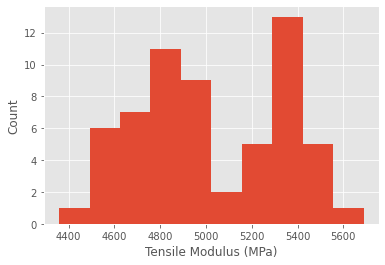

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

modulus = np.loadtxt('../../data/bopet_modulus-MPa.csv')

fig, ax = plt.subplots() 

ax.hist(modulus)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Count')

We have options in how we can set up the bins. In addition to the data array. The `hist()` function has an additional parameter called `bins` that can be used to either set a number of bins, or to fix the bin edges. In the example below, we set the bin count to 50. While it might seem like more bins will always improve resolution, there is a point at which you make the bins too narrow and you lose sight of the distribution.

Text(0, 0.5, 'Density')

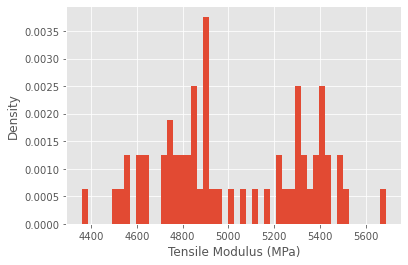

In [2]:
fig, ax = plt.subplots() 

ax.hist(modulus, bins=50, density=True)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Density')

Additionally, you can set the actual bin edges. Recall the `np.arange()` function that we learned in Unit 2.

Text(0, 0.5, 'Count')

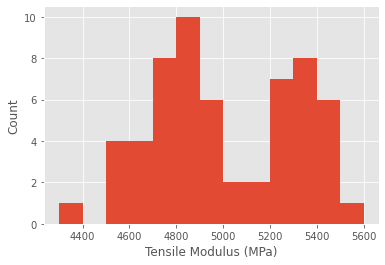

In [3]:
bin_edges = np.arange(4300, 5700, 100)

fig, ax = plt.subplots() 

ax.hist(modulus, bins=bin_edges)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Count')

### Calculating the histogram values in `numpy`

Sometimes, it is helpful to have the actual data, so that you can do something with it, like plotting a 

In [4]:
counts, bins = np.histogram(modulus, bins=bin_edges)

counts, bins

(array([ 1,  0,  4,  4,  8, 10,  6,  2,  2,  7,  8,  6,  1], dtype=int64),
 array([4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300,
        5400, 5500, 5600]))

(array([ 1.,  0.,  4.,  4.,  8., 10.,  6.,  2.,  2.,  7.,  8.,  6.,  1.]),
 array([4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300,
        5400, 5500, 5600]))

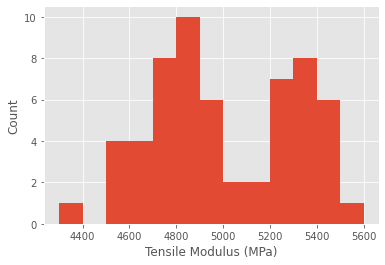

In [5]:
fig, ax = plt.subplots() 

counts, bins, bars = ax.hist(modulus, bins=bin_edges)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Count')

counts, bins

### 5.1.2. Adding the cumulative sum

Text(0, 0.5, 'Count')

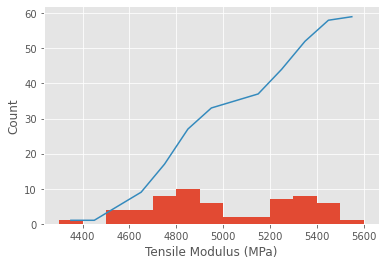

In [6]:
fig, ax = plt.subplots() 

counts, bins, bars = ax.hist(modulus, bins=bin_edges)
ax.plot(bins[0:-1] + 50, counts.cumsum())

ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

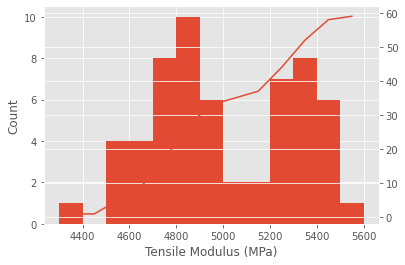

In [7]:
fig, ax = plt.subplots() 

counts, bins, bars = ax.hist(modulus, bins=bin_edges)
ax2 = ax.twinx()
ax2.plot(bins[0:-1] + 50, counts.cumsum())

ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Count')

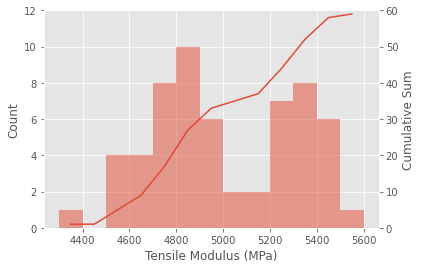

In [8]:
fig, ax = plt.subplots() 

counts, bins, bars = ax.hist(modulus, bins=bin_edges, alpha=0.5)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Count')
ax.set_ylim((0, 12))

ax2 = ax.twinx()
ax2.plot(bins[0:-1] + 50, counts.cumsum())
ax2.set_ylabel('Cumulative Sum')
ax2.set_ylim((0, 60))
ax2.grid(False)


### 5.1.3. Overlaying the normal distribution

In the Unit 1 problems, we created a custom function for the Gaussian (normal) continuous probability distribution.

$$f(x)=\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\frac{\left(x-\mu\right)^2}{\sigma^2}}$$

While this method works, it's more efficient to assume that someone else has already created a module to address common needs like this. The `scipy` project includes a package for statistical analysis called [`scipy.stats`](https://docs.scipy.org/doc/scipy/tutorial/stats.html), which includes many common probability distributions.

In this example, we import the package using the line `from scipy import stats`, which imports only the `stats` package from the broader `scipy` project. In the subsequent code, we will preference any calls from this package with `stats.`.

Here, we create a normal probability distribution object, with a given mean and standard deviation. In the `scipy.stats` package, the paramater `loc` is the mean and `scale` is the standard deviation. Then, we use the `pdf(x)` function to calculate the value of the probability density function.

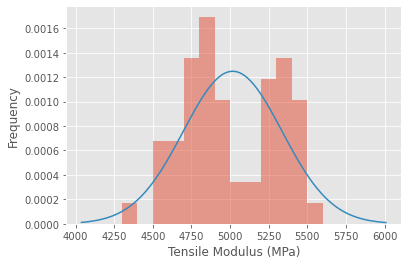

In [26]:
from scipy import stats

fig, ax = plt.subplots() 

counts, bins, bars = ax.hist(modulus, bins=bin_edges, density=True, alpha=0.5)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Frequency')

x = np.linspace(modulus.min()-modulus.std(), modulus.max()+modulus.std(), 100)

# create an normal probability distribution object
norm_dist = stats.norm(loc=modulus.mean(), scale=modulus.std())

# calculate the value of the probability density function for each value in x
norm_pdf = norm_dist.pdf(x)

# overlay the probability density function
ax.plot(x, norm_pdf)


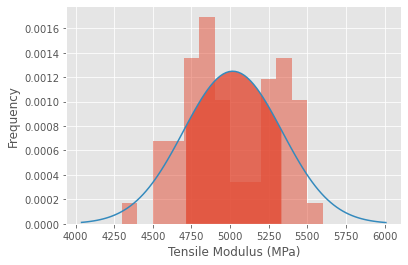

In [10]:
fig, ax = plt.subplots() 

counts, bins, bars = ax.hist(modulus, bins=bin_edges, density=True, alpha=0.5)
ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Frequency')

x = np.linspace(modulus.min()-modulus.std(), modulus.max()+modulus.std(), 100)
pdf = stats.norm.pdf(x, loc=modulus.mean(), scale=modulus.std())


lower_limit = modulus.mean() - modulus.std()
upper_limit = modulus.mean() + modulus.std()

ax.plot(x, pdf)
ax.fill_between(x, 0, pdf, where=((x>lower_limit) & (x<upper_limit)), alpha=0.8)



## 5.2. Constructing a run chart of the results

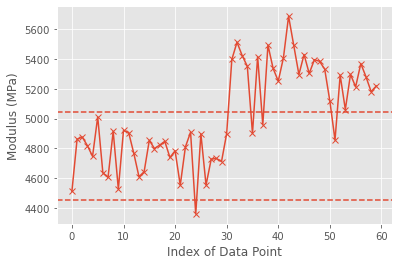

In [11]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(modulus)), modulus, marker='x')
ax.set_xlabel('Index of Data Point')
ax.set_ylabel('Modulus (MPa)')

mean_first30 = modulus[:30].mean()
std_first30 = modulus[:30].std()

ax.axhline(mean_first30+2*std_first30, ls='--')
ax.axhline(mean_first30-2*std_first30, ls='--')

## 5.3. Testing 2 separate distributions

Based on what we learned in the previous section, we may want to conduct a statistical test to determine if these two sets of data are likely from the same distribution. 

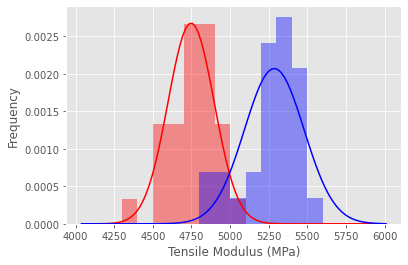

In [20]:
from scipy import stats

fig, ax = plt.subplots() 

# plotting the first and second half of the data separately
# here, setting the transparency (alpha) to 40% helps visualize overlap
ax.hist(modulus[:30], bins=bin_edges, density=True, color='red', alpha=0.4)
ax.hist(modulus[30:], bins=bin_edges, density=True, color='blue', alpha=0.4)

ax.set_xlabel('Tensile Modulus (MPa)')
ax.set_ylabel('Frequency')

# overlay the standard normal distributions for the two sets
x = np.linspace(modulus.min()-modulus.std(), modulus.max()+modulus.std(), 100)

pdf_first30 = stats.norm.pdf(x, loc=modulus[:30].mean(), scale=modulus[:30].std())
pdf_last30 = stats.norm.pdf(x, loc=modulus[30:].mean(), scale=modulus[30:].std())

ax.plot(x, pdf_first30, color='red')
ax.plot(x, pdf_last30, color='blue')

## 5.4. Additional features of a probability distribution

### 5.4.1. Cumulative probability distributions

In addition to the probability density function (`pdf`), `scipy.stats` provides other useful functions for working with these probability distributions. For instance, for any continuous probability distribution function, we can define the continuous distribution function as

$$cdf(x)=\int\limits_{-\infty}^{x}pdf(x)dx$$

As you can see, this is the probability of any value less than `x` ($P<x$). This can be calculated by using the function `cdf(x)`. 

Alternatively, we may also need to calculate the probability of a value greater than `x` ($P>x$), which uses the *survival function* (`sf(x)`). Because the total area of the pdf function is equal to 1, we can look at these as equal.

$$sf(x)=\int\limits_{x}^{\infty}pdf(x)dx=1-\int\limits_{-\infty}^{x}pdf(x)dx$$

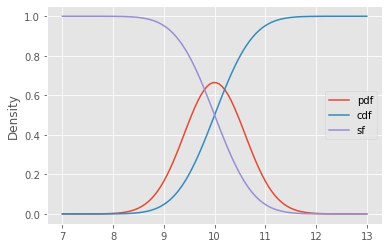

In [50]:
norm_dist = stats.norm(loc=10, scale=0.6)

x = np.linspace(7, 13, 100)
norm_pdf = norm_dist.pdf(x)
norm_cdf = norm_dist.cdf(x)
norm_sf = norm_dist.sf(x)

fig, ax = plt.subplots()
ax.plot(x, norm_pdf, label='pdf')
ax.plot(x, norm_cdf, label='cdf')
ax.plot(x, norm_sf, label='sf')

ax.set_ylabel('Density')
ax.legend()


We also have the inverse of the `cdf` and `isf` functions available.

| Function | Inverse | Description |
|----------|---------|-------------|
| `cdf(x)` | `ppf(p)` | *percentage point function*: at what *X'* is $P(x<X')=p$ |
| `sf(x)` | `isf(p)` | *inverse survival function*: at what *X'* is $P(x>X')=p$ |

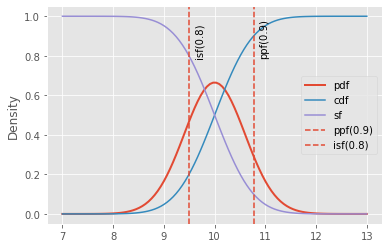

In [72]:
fig, ax = plt.subplots()
ax.plot(x, norm_pdf, lw=2, label='pdf')
ax.plot(x, norm_cdf, label='cdf')
ax.plot(x, norm_sf, label='sf')

x_ppf = norm_dist.ppf(0.9)
ax.axvline(x_ppf, ls='--', label='ppf(0.9)')
ax.text(x_ppf+0.1, 0.8, 'ppf(0.9)', rotation='vertical')

x_isf = norm_dist.isf(0.8)
ax.axvline(x_isf, ls='--', label='isf(0.8)')
ax.text(x_isf+0.1, 0.8, 'isf(0.8)', rotation='vertical')


ax.set_ylabel('Density')
ax.legend()


### 5.4.2. Sampling random values from the distribution

We may also want to run an experiment by generating random values from the normal distribution. Recall that in Unit 2, we created random values from a flat probability distribution using `numpy.random`. We can use the normal probability distribution object created in the cell above, and generate an array of random values from the distribution using the function `rvs` (random values). This function takes a parameter named `size` which is the length of the array that will be generated. 

Text(0, 0.5, 'Density')

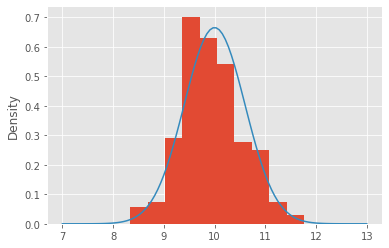

In [52]:
norm_random = norm_dist.rvs(size=200)

fig, ax = plt.subplots()
ax.hist(norm_random, density=True)
ax.plot(x, norm_pdf, label='pdf')

ax.set_ylabel('Density')

## 5.5. Measurement Variability

### 5.5.1 Central Limit Theorem

Consider a set of laboratory measurements. We already know how to calculate the mean and standard deviation of the data. What do we do if there is a high degree of variability in the data? Intuitively, we might take multiple measurements, and average them together, to reduce noise in the data. 

The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) describes what happens if we randomly draw $n$ samples from population with a mean, $\mu$, and standard deviation, $\sigma$. We can average the samples to get the variable $\bar{x}_n$. The standard deviation of the averages will decrease as $n$ increases:

$$\sigma_{\bar{x}}=\frac{\sigma}{\sqrt{n}}$$

So, as we average more samples, we reduce variability and improve the power of our measurement. An illustration of the effect of averaging is shown below.

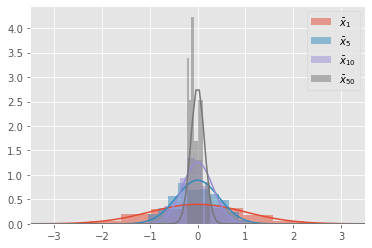

In [124]:
total_vals = 1200
norm_random = stats.norm().rvs(size=total_vals)

# plot the histogram, with the normal pdf
fig, ax = plt.subplots()
ax.set_xlim((-3.5, 3.5))

x = np.linspace(-3.5, 3.5, 100)

# number of measurements to average together
n_to_average = [1, 5, 10, 50]

for n in n_to_average:

    # reshape the 1d array into a 2d matrix (number of cols = n)
    norm_reshape = norm_random.reshape((int(total_vals/n), n))

    # take the mean across the replicate measurements in each row
    norm_means = norm_reshape.mean(axis=1)

    # add a histogram of the averaged values to the axis
    counts, bins, patches = ax.hist(norm_means, density=True, alpha=0.5, 
                                    label=f'$\\bar{{x}}_{{{n}}}$')
    
    # get the color to match the normal pdf to the histogram
    color = patches[0].get_facecolor()

    # add the standard normal pdf to the axis
    ax.plot(x, stats.norm(loc=0, scale=1/np.sqrt(n)).pdf(x), c=color, alpha=1)

ax.legend()



### 5.5.2. Determining significance

--------------
## Next Steps:

1. Complete the [Unit 5 Problems](./unit05-solutions.ipynb) to test your understanding
2. Advance to [Unit 6](../06-regression-classification/unit06-lesson.ipynb) when you're ready for the next step